In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import PIL
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tqdm
import copy

In [0]:
batch_size=128
lr=1e-3
num_epochs = 30

In [0]:
transforms_dict = {'train':torchvision.transforms.Compose([
                                                           torchvision.transforms.RandomHorizontalFlip(),
                                                           torchvision.transforms.ToTensor(),
                                                           torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                           ]),
                   'test':torchvision.transforms.Compose([
                                                          torchvision.transforms.ToTensor(),
                                                          torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                   ])    
}

In [4]:
train_ds = torchvision.datasets.CIFAR10(root='.',train=True,transform=transforms_dict['train'],download=True)
test_ds = torchvision.datasets.CIFAR10(root='.',train=False, transform=transforms_dict['test'], download=True)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


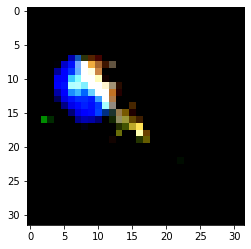

In [9]:
plt.imshow(next(iter(train_dl))[0][0].permute(1,2,0))

In [0]:
class Encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # 32x32 -> 16x16
    self.block1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, 4, 2, 1),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),        
    )
    
    # 16x16 -> 8x8
    self.block2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, 4, 2, 1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU()
    )

    # 8x8 -> 4x4
    self.block3 = torch.nn.Sequential(
        torch.nn.Conv2d(64, 128, 4, 2, 1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU()
    )

    # 4x4 -> 2x2
    self.block4 = torch.nn.Sequential(
        torch.nn.Conv2d(128, 256, 4, 2, 1),
        torch.nn.Tanh()
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

class Decoder(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # 2x2 -> 4x4
    self.block1 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(256, 128, 4, 2, 1),
        torch.nn.BatchNorm2d(128),
        torch.nn.LeakyReLU()
    )

    # 4x4 -> 8x8
    self.block2= torch.nn.Sequential(
        torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
        torch.nn.BatchNorm2d(64),
        torch.nn.LeakyReLU()
    )

    # 8x8 -> 16x16
    self.block3 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(64,32,4,2,1),
        torch.nn.BatchNorm2d(32),
        torch.nn.LeakyReLU()
    )

    # 16x16 -> 32x32
    self.block4 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(32, 3, 4, 2, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

enc, dec = Encoder(), Decoder()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


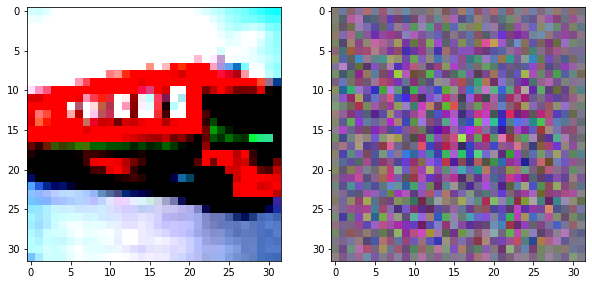

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(next(iter(train_dl))[0][0].permute(1,2,0))

plt.subplot(1,2,2)
plt.imshow(dec(enc(next(iter(train_dl))[0][0].unsqueeze(0)))[0].detach().permute(1,2,0))

In [0]:
class CAE(torch.nn.Module):
  """Convolutional AutoEncoder"""
  def __init__(self):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

  def forward(self, x):
    x = self.enc(x)
    x = self.dec(x)
    return x

  def get_enc(self):
    return copy.deepcopy(self.enc)

  def get_dec(self):
    return copy.deepcopy(self.dec)

In [0]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
net = CAE()
net.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
idx = 0


Epoch 1: loss: 0.74667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 1: loss: 0.66888


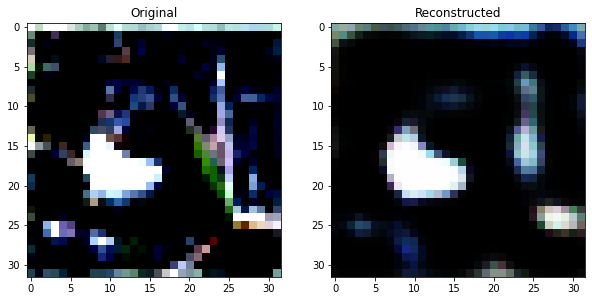


Epoch 2: loss: 0.66921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 2: loss: 0.65201


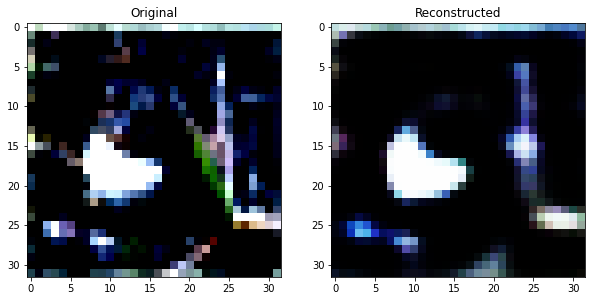


Epoch 3: loss: 0.65863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 3: loss: 0.64540


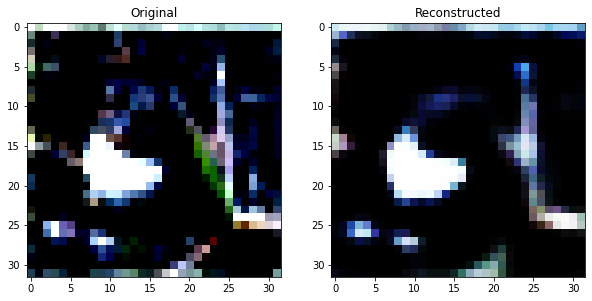


Epoch 4: loss: 0.65371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 4: loss: 0.64313


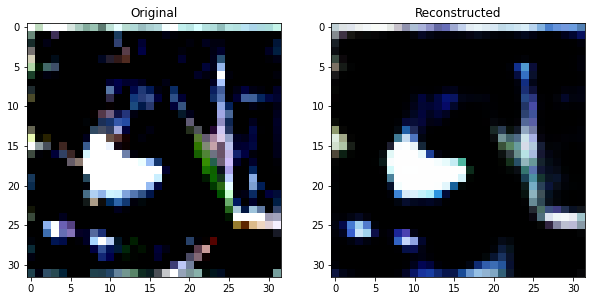


Epoch 5: loss: 0.65080


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 5: loss: 0.64135


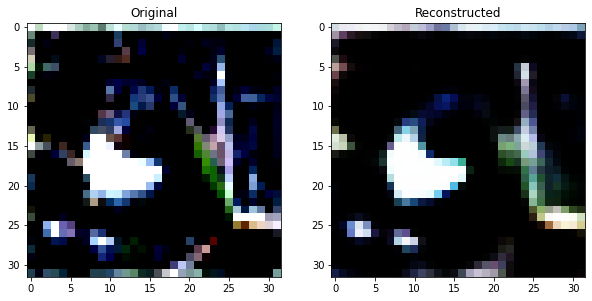


Epoch 6: loss: 0.64938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 6: loss: 0.63970


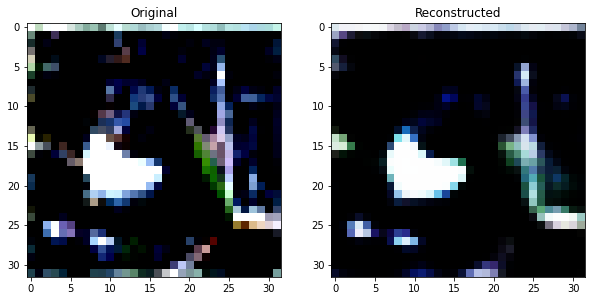


Epoch 7: loss: 0.64764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 7: loss: 0.63772


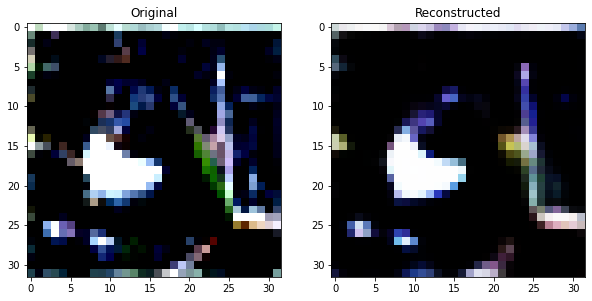


Epoch 8: loss: 0.64656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 8: loss: 0.63633


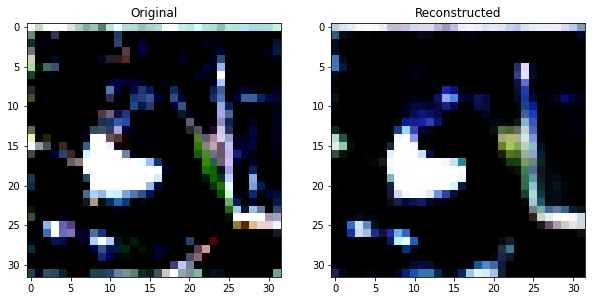


Epoch 9: loss: 0.64578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 9: loss: 0.63565


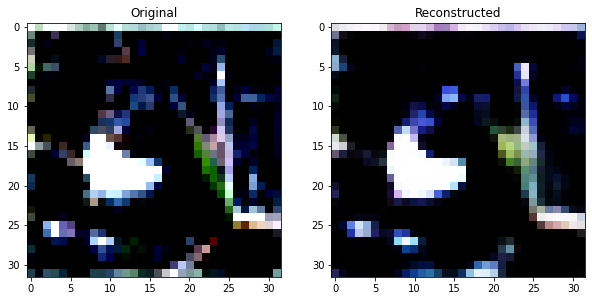


Epoch 10: loss: 0.64489


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 10: loss: 0.63598


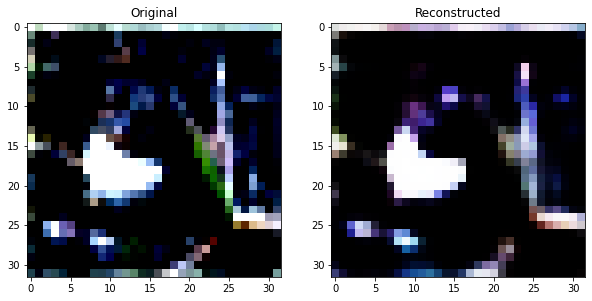


Epoch 11: loss: 0.64447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 11: loss: 0.63509


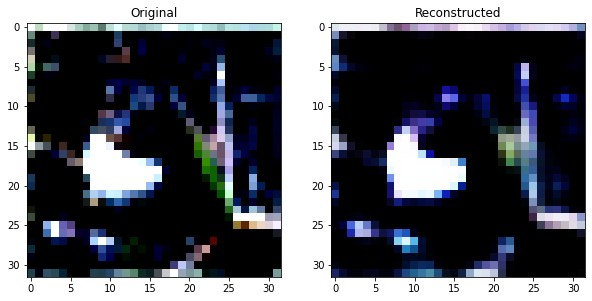


Epoch 12: loss: 0.64406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 12: loss: 0.63541


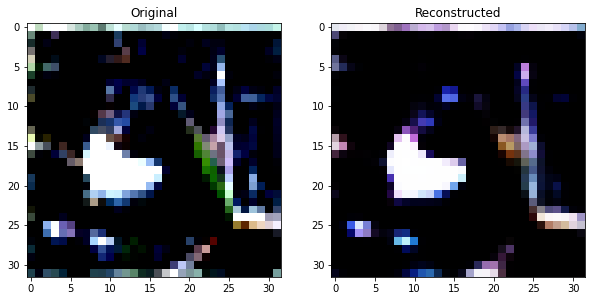


Epoch 13: loss: 0.64366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 13: loss: 0.63400


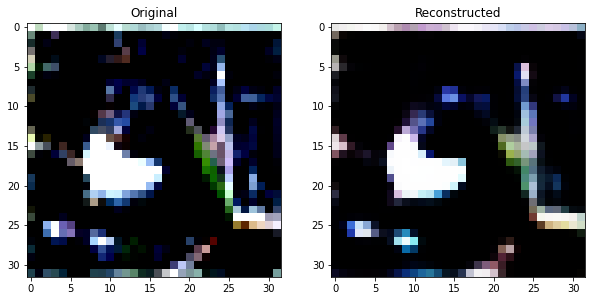


Epoch 14: loss: 0.64292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 14: loss: 0.63298


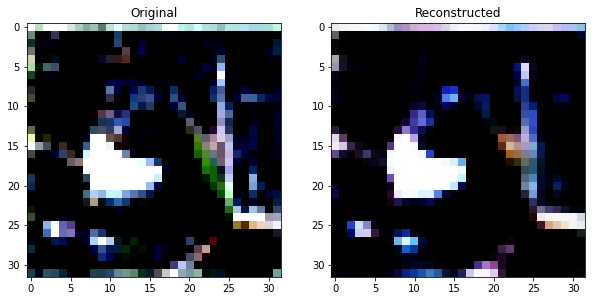


Epoch 15: loss: 0.64267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 15: loss: 0.63320


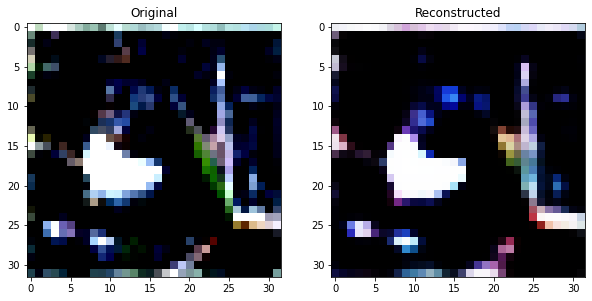


Epoch 16: loss: 0.64192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 16: loss: 0.63204


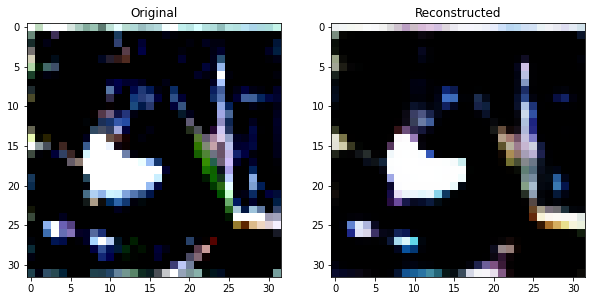


Epoch 17: loss: 0.64124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 17: loss: 0.63135


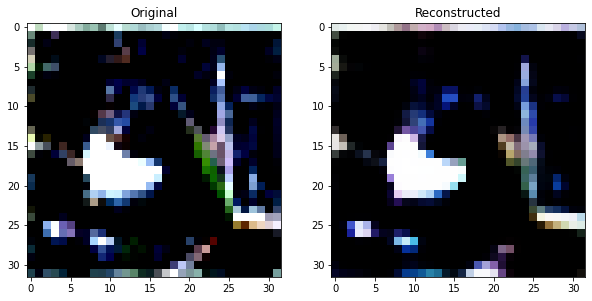


Epoch 18: loss: 0.64076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 18: loss: 0.63168


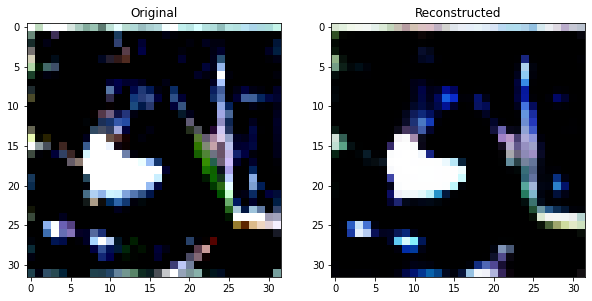


Epoch 19: loss: 0.64034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 19: loss: 0.63059


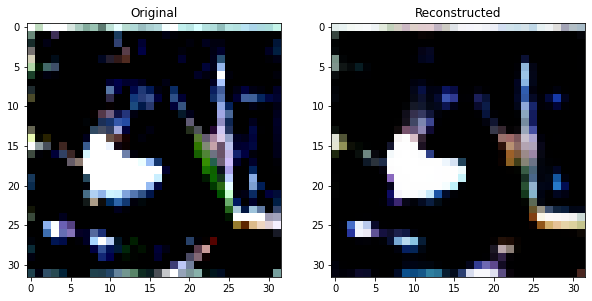


Epoch 20: loss: 0.63973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 20: loss: 0.63087


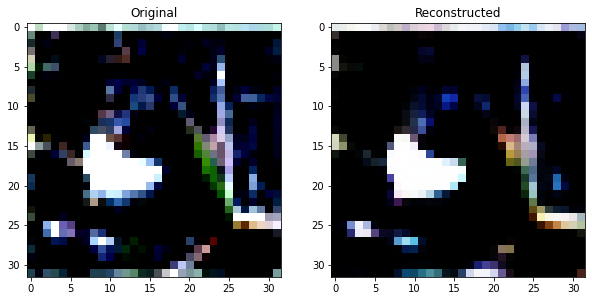


Epoch 21: loss: 0.63936


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 21: loss: 0.63028


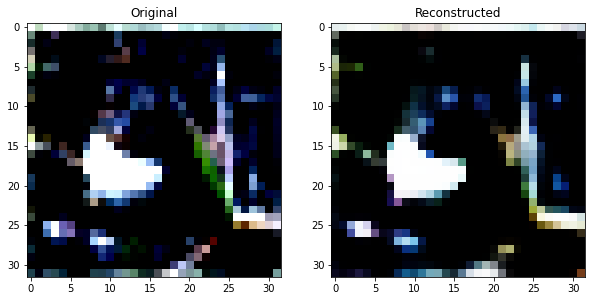


Epoch 22: loss: 0.63908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 22: loss: 0.62985


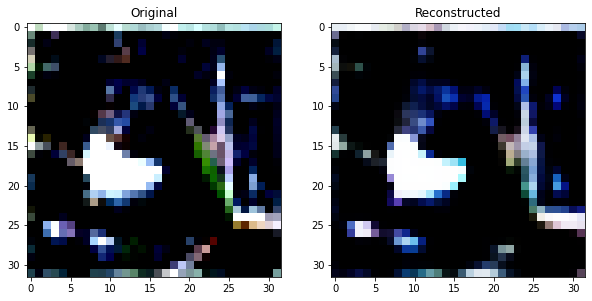


Epoch 23: loss: 0.63879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 23: loss: 0.62972


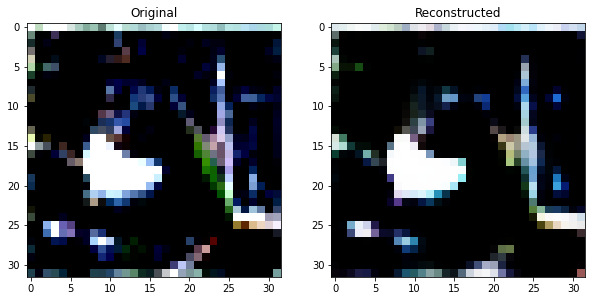


Epoch 24: loss: 0.63853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 24: loss: 0.62921


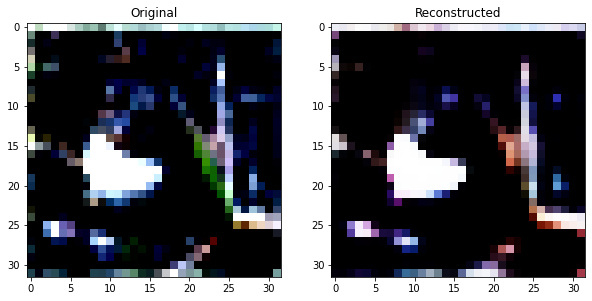


Epoch 25: loss: 0.63797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 25: loss: 0.62872


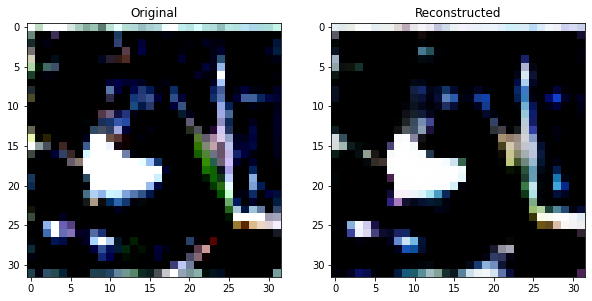


Epoch 26: loss: 0.63782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 26: loss: 0.62854


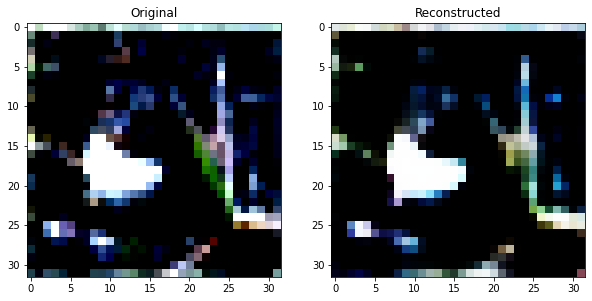


Epoch 27: loss: 0.63740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 27: loss: 0.62836


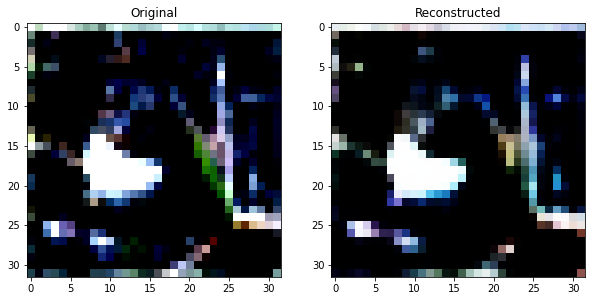


Epoch 28: loss: 0.63711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 28: loss: 0.62804


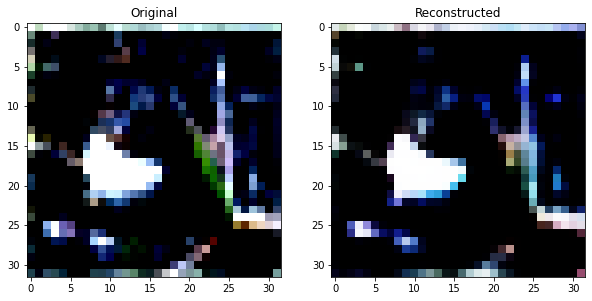


Epoch 29: loss: 0.63666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 29: loss: 0.62762


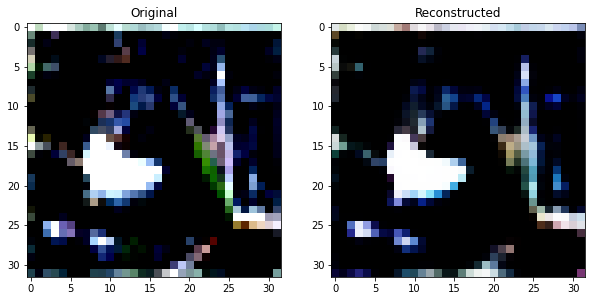


Epoch 30: loss: 0.63656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 30: loss: 0.62740


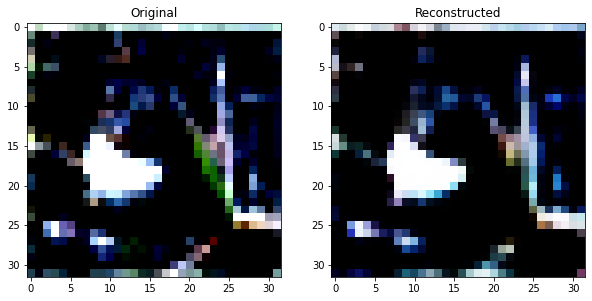

In [19]:
for epoch in range(num_epochs):
  epoch_loss = 0.
  for (data, _) in tqdm.notebook.tqdm(train_dl):
    net.train()
    data = data.to(device)
    optimizer.zero_grad()
    output = net(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()
  print("Epoch {}: loss: {:.5f}".format(epoch+1, epoch_loss/len(train_ds)))

  val_loss = 0. 
  for (data, _) in tqdm.notebook.tqdm(test_dl):
    net.eval()
    data = data.to(device)
    with torch.no_grad():
      output = net(data)
      loss = criterion(output, data)
    val_loss += loss.item()
  print("Val {}: loss: {:.5f}".format(epoch+1, val_loss/len(test_ds)))

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(data[idx].cpu().detach().permute(1,2,0))
  plt.title('Original')
  plt.subplot(1,2,2)
  plt.imshow(output[idx].cpu().detach().permute(1,2,0))
  plt.title('Reconstructed')

plt.pause(0.01)